In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib

#connecting to local SQL database with reddit nba submissions
sql_db = 'reddit_db.sqlite'
conn = sqlite3.connect(sql_db)
cur = conn.cursor()

'''we only need timestamp,submission score and subreddit name for each submission, so we will obtain
this data with the following SQL query'''
cur.execute('''
SELECT NBA_submissions.date_created,NBA_submissions.submission_score,NBA_subs.sub_name FROM NBA_submissions,NBA_subs WHERE NBA_submissions.team_id = NBA_subs.id
''')

#we will put this data in a data frame object named 'nba_reddit'
nba_reddit = pd.DataFrame(data=cur.fetchall(),columns=["Timestamp","sub_score",'subr_name'])

#lets preview the first 3 rows of our data
nba_reddit.head(3)


,Timestamp,sub_score,subr_name
0,2011-12-28 04:32:27 UTC,14,atlantahawks
1,2011-12-18 15:27:42 UTC,9,atlantahawks
2,2011-12-16 19:26:26 UTC,4,atlantahawks


The date values in our Timestamp column are str objects. We want to take advantage of pandas builtin datetime object to make our lives easier so we will convert the column below.

In [8]:
nba_reddit["Timestamp"] = nba_reddit['Timestamp'].apply(lambda x: pd.to_datetime(x))
print(type(nba_reddit['Timestamp'].iloc[1]))
nba_reddit.head(3)

<class 'pandas._libs.tslib.Timestamp'>


,Timestamp,sub_score,subr_name
0,2011-12-28 04:32:27,14,atlantahawks
1,2011-12-18 15:27:42,9,atlantahawks
2,2011-12-16 19:26:26,4,atlantahawks


### Growth of NBA related subreddits by # of submissions over time###
Let's take a look at the growth of /r/nba and all the teams specific subreddits by the number of total submissions


First we lets look at the dates of the first submissions for each subreddit to get a feel for when these subreddits first emerged. 

In [9]:
#we will store data on the earliest submissions per subreddit in our variable 'earliest_subs'
#we will also sort them by date and retrieve the earliest 3 and latest 3 submissions
earliest_subs = nba_reddit.iloc[nba_reddit.groupby('subr_name')['Timestamp'].idxmin()]
earliest_subs = earliest_subs.set_index('Timestamp')
earliest_subs = earliest_subs.sort_index()

#mapping subreddits by their ordinal position in terms of earliest post to latest
earliest_subs['yval'] = range(1,32)

print('Earliest submissions:')
print(earliest_subs['subr_name'].head(3))
print('\n')
print('Latest submissions:')
print(earliest_subs['subr_name'].tail(3))


Earliest submissions:
Timestamp
2008-04-25 22:45:29           lakers
2008-09-22 19:38:17    bostonceltics
2008-12-06 20:38:10              nba
Name: subr_name, dtype: object


Latest submissions:
Timestamp
2012-04-19 18:52:07    charlottehornets
2012-06-29 23:18:13             rockets
2013-01-25 00:50:03        nolapelicans
Name: subr_name, dtype: object


The first submission that appeared on an NBA related subreddit occured on April 25th, 2008 on the Los Angeles Lakers subreddit (/r/lakers). We see that the Laker's archrivals the Boston Celtics came in 2nd by about 5 months, their first submission didnt appear till that September. The NBA subreddit itself had its first post that December.
These findings are not too surprising as both the Lakers and the Celtics are two of the most storied franchises in NBA history and as a result each have legions of committed fans.

The latest subreddit post was on the New Orleans Pelicans subreddit on January 25th, 2013, 5 years after the Lakers subreddit emerged! Why is this so? Was this a new expansion team? What about the Houston Rockets and Charlotte Hornets? The Pelicans were originally established as the New Orleans Hornets in 2002 taking the place of the Charlotte Hornets team that itself was originally founded in 1988. Basically the Hornets moved from Charlotte to New Orleans in 2002. Then in 2004 the NBA announced a new expansion team, the Charlotte Bobcats. Once 2013 came around the New Orleans Hornets rebranded themselves as the New Orleans Pelicans, now because the 'Hornets' mascot was now available the Charlotte Bobcats also changed from Bobcats to Hornets.

So this means we missed collecting submission data from the subreddits these teams used to occupy. After some digging I found that this now unused subreddit was /r/hornets. I will go back and rerun the python script to add this to our database, but we will just rename it under the Charlotte Hornets submissions.

What about the Houston Rockets? Well they have been a team since 1971, so its not so clear cut why it took so long for their first submission post to appear. It's possible that they existed on a different subreddit besides /r/rockets but with the little digging I did I was not able to find it.

In [529]:
import matplotlib

In [1]:
#Lets visually take a look at when these first submissions appeared per subreddit
plt.style.use('fivethirtyeight')
#mapping y axis values for y team labels in graph below
val_dict = dict()
for i in range(len(earliest_subs)):
    val_dict[i+1] = str(earliest_subs.index[i].date()) + '-' + earliest_subs['subr_name'].iloc[i]

#making a list as well in correct ordinal order
subr_list = [val_dict[i].split('-')[3] for i in range(1,32)]


# make the plot
fig, ax = plt.subplots()
earliest_subs['yval'].plot(ax=ax, style='ks',ms=15,marker='.',figsize=(6,10));
ax.set_ylim([0,32])
ax.set_yticks(np.arange(1,32, 1.00));
ax.set_xlim(['2008-01-01','2013-06-01'])
ax.set_yticklabels(subr_list, fontsize=15);

#alternate way of setting custom y labels by using dict to map to y values
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))


NameError: name 'plt' is not defined

In [612]:
#creating new column Day so we can count total submissions created per day and store it in a new variable
nba_subs['Day'] = nba_subs['Timestamp'].apply(lambda x: x.date())
ttlsubs_pday = nba_subs.groupby('Day').count()

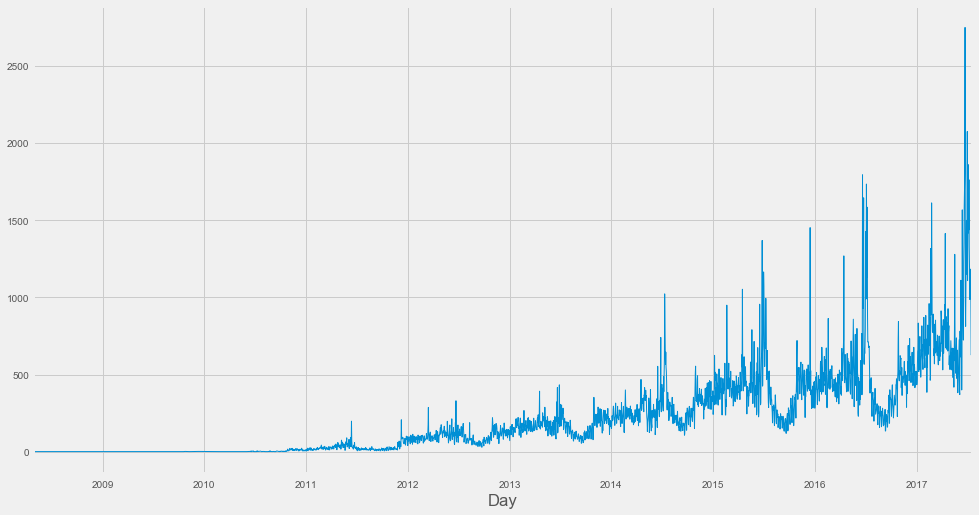

In [630]:
fig,ax = plt.subplots()
ttlsubs_pday['subreddit'].plot(ax=ax,ls='-',lw='1',figsize=(15,8))
ax.


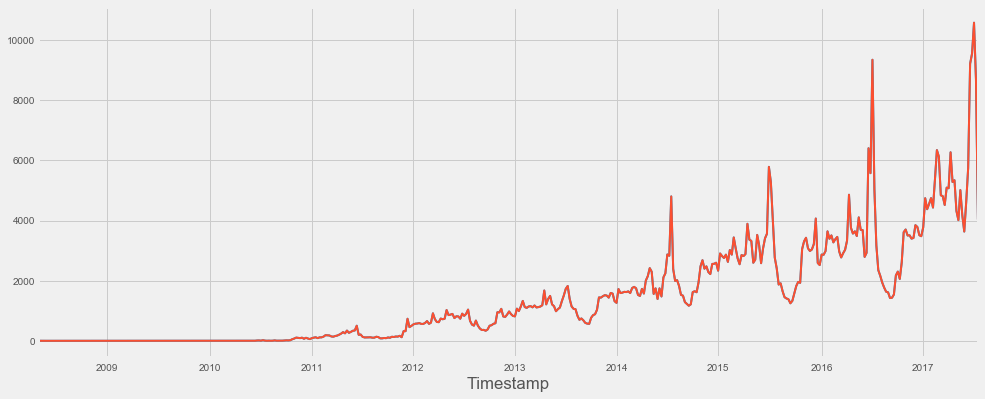

In [657]:
ttlsubs_pweek = nba_subs.set_index('Timestamp').groupby(pd.TimeGrouper(freq='W-THU')).count()

ttlsubs_pweek.plot(figsize=(15,6),legend=False,lw=2)


#freq attribute takes in anchor attributes - see here 
#http://pandas.pydata.org/pandas-docs/stable/timeseries.html#anchored-offsets

In [98]:
main_sub = nba_subs[nba_subs['subreddit']=='nba']


main_sub['Day of Week'] = main_sub['Timestamp'].apply(lambda x: x.dayofweek)
main_sub['Year'] = main_sub['Timestamp'].apply(lambda x: x.year)

#weekmap = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

#main_sub['Day of Week'] = main_sub['Day of Week'].map(weekmap)
for year_day = main_sub.groupby(['Year','Day of Week']).size()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


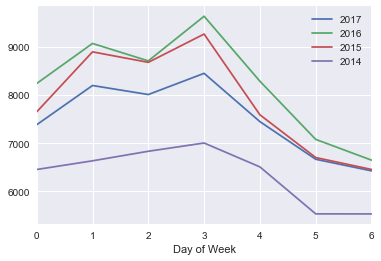

In [113]:
for yr in [2017,2016,2015,2014]:
    main_sub[main_sub['Year']==yr].groupby('Day of Week').count()['subreddit'].plot(label='{}'.format(yr))
plt.legend()

In [129]:
-dteam_list = list(nba_subs['subreddit'].unique())
team_list

['atlantahawks',
 'bostonceltics',
 'chicagobulls',
 'clevelandcavs',
 'denvernuggets',
 'detroitpistons',
 'gonets',
 'heat',
 'kings',
 'laclippers',
 'lakers',
 'mavericks',
 'memphisgrizzlies',
 'mkebucks',
 'nba',
 'nbaspurs',
 'nyknicks',
 'orlandomagic',
 'pacers',
 'ripcity',
 'sixers',
 'suns',
 'thunder',
 'timberwolves',
 'torontoraptors',
 'utahjazz',
 'warriors',
 'washingtonwizards',
 'charlottehornets',
 'nolapelicans',
 'rockets']

In [203]:
moyr_dict = {}

for team_name in team_list:

    moyr_dict[team_name] = nba_subs[nba_subs['subreddit']==team_name]

lakers_time['Month'] = lakers_time['Timestamp'].apply(lambda x: x.month)
lakers_time['Yr'] = lakers_time['Timestamp'].apply(lambda x: x.year)

for key in moyr_dict:
    moyr_dict[key]['Month'] = moyr_dict[key]['Timestamp'].apply(lambda x: x.month)
    moyr_dict[key]['Yr'] = moyr_dict[key]['Timestamp'].apply(lambda x: x.year)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

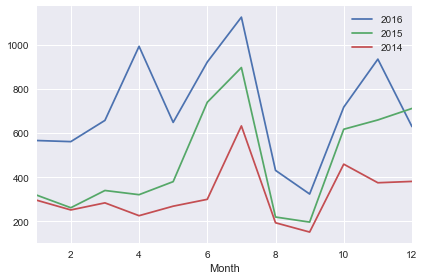

In [204]:
for in_year in [2016,2015,2014]:
    lakers_time[lakers_time['Yr']==in_year].groupby('Month').count()['subreddit'].plot(label=str(in_year))

plt.tight_layout()
plt.legend()

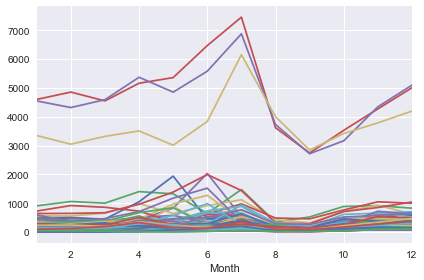

In [207]:
for in_year in [2016,2015,2014]:
    for key in moyr_dict:
        team_df = moyr_dict[key]
        team_df[team_df['Yr']==in_year].groupby('Month').count()['subreddit'].plot(label=str(in_year))

plt.tight_layout()
